In [2]:
import torch
import plotly.graph_objects as go
import numpy as np

# Divergence-based aqcuisition functions

- KL-divergence is asymmetric which in this use case does not make as much sense
- Jensen-Shannon (JS) divergence is the symmetric and smooth alternative
    - It actually is based on the mixture distribution
    - bounded nature: problematic for acquisition function
    - Approximate it by taking the average of both KLs (are always non-negative)
    - geometric Jensen–Shannon divergence
    - entropy based measures: 
    - https://stats.stackexchange.com/questions/8634/jensen-shannon-divergence-for-bivariate-normal-distributions
    - Cauchy-Schwarz divergence: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6033555 
- GMM: (equal parts mixture of both)
- Bayeisan update but this would be underestmate the uncertainty
- overlapping zone of distribution: 

$c =    \frac{\mu _2 \sigma _1^2-\sigma _2 \left(\mu _1 \sigma _2+\sigma _1 \sqrt{\left(\mu _1-\mu _2\right){}^2+2 \left(\sigma _1^2-\sigma _2^2\right) \log \left(\frac{\sigma _1}{\sigma _2}\right)}\right)}{\sigma _1^2-\sigma _2^2}$

P: observed distribution
Q: reference distribution (e.g. Normal)

In [17]:
# define distribution params
mu_q, std_q = torch.tensor(10), torch.tensor(2)
# mu_p, std_p = torch.tensor(10), torch.tensor(4)
mu_p, std_p = torch.tensor(6), torch.tensor(1.5)

# https://pytorch.org/docs/stable/distributions.html#normal
# reference distribution (normaliser)
q_dist = torch.distributions.normal.Normal(loc = mu_q, scale = std_q)
# new distribution we want to compare to reference (e.g. approximation of q)
p_dist = torch.distributions.normal.Normal(loc = mu_p, scale = std_p)

## Mixture distribution M (GMM)

$
M(x) = \frac{1}{2} P(x) + \frac{1}{2} Q(x)
$

- equal-part mixing of P and Q distributions
- division by 2 so it remains a pdf (adds up to 1)
- the mixture is not Gaussian if either mean or variance diverge

### Alternative: Simple Gaussian Approximation of a M 
$
\mu_M = \frac{\mu_1 + \mu_2}{2}
$  
$
\sigma_M^2 = \frac{\sigma_1^2 + \sigma_2^2 + \frac{(\mu_1 - \mu_2)^2}{4}}{2}
$

In [18]:
# In pytorch there is https://pytorch.org/docs/stable/distributions.html#mixturesamefamily
# two equally weighted ("selecting" distribution)
mix = torch.distributions.Categorical(torch.ones(2,))

# two normal distributions (different parameterizations of the same distribution type)
comp = torch.distributions.Normal(
    torch.cat((mu_p.unsqueeze(0), mu_q.unsqueeze(0)), dim = 0), 
    torch.cat((std_p.unsqueeze(0), std_q.unsqueeze(0)), dim = 0))

# Gaussian mixture distribution
gm_dist = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)

In [19]:
# SGA (Simple Gaussian Approximation)
mu_sga = 0.5*(mu_p + mu_q)
# sqrt to get std
std_sga = (0.5*(std_p**2 + std_q**2 + ((mu_p - mu_q)**2)*0.25)).sqrt()

sga_dist = torch.distributions.normal.Normal(loc = mu_sga, scale = std_sga)

# define x values to pass into pdf
x = torch.arange(start = 0, end = 20, step = 0.1, dtype = torch.float32)

# exponent to get pdf value
q = q_dist.log_prob(x).exp()
p = p_dist.log_prob(x).exp()

sga = sga_dist.log_prob(x).exp()
# gm is the same as 0.5*(p + q)
gm = gm_dist.log_prob(x).exp()

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = x, y = p, name = "P", line = dict(color = 'forestgreen', width = 4, dash = 'solid')))
fig.add_trace(go.Scatter(x = x, y = q, name = "Q", line = dict(color = 'blue', width = 4, dash = 'solid')))
# fig.add_trace(go.Scatter(x = x, y = sga, name = "SGA", fillcolor = "green"))
fig.add_trace(go.Scatter(x = x, y = gm, name = "Gaussian Mixture", line = dict(color = 'purple', width = 4, dash = 'dot')))
# fig.add_trace(go.Scatter(x = x, y = 0.5*(p+q), name = "Gaussian Mixture", fillcolor = "green"))

fig.update_layout(title = "Normal Distribution PDF", xaxis_title = "x", yaxis_title = "pdf", template = "plotly_white")
fig.show()

In [43]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = x, y = p, name = "P (e.g. gravitational mass balance)", line = dict(color = 'forestgreen', width = 4, dash = 'solid')))
fig.add_trace(go.Scatter(x = x, y = q, name = "Q (e.g. altimetry mass balance)", line = dict(color = 'blue', width = 4, dash = 'solid')))

fig.update_layout(title = "Normal Distribution PDF", xaxis_title = "x", yaxis_title = "pdf", template = "plotly_white")
fig.show()

In [36]:
interval = torch.tensor([0.05, 0.95])
mean_interval = torch.tensor([0.5])

# inverse cumulative density/mass function
print(q_dist.icdf(interval))
print(p_dist.icdf(interval))
# Not Implemented: print(gm_dist.icdf(interval))
# Only forward is implemented: gm_dist.cdf(torch.tensor([8.0]))

lower, upper = torch.tensor([0.05]), torch.tensor([0.95])

# inverse cumulative density/mass function of components
q_lower, q_upper = q_dist.icdf(lower), q_dist.icdf(upper)
p_lower, p_upper = p_dist.icdf(lower), p_dist.icdf(upper)

# Gaussian approximation params
ga_lower, ga_upper = min(q_lower, p_lower), max(q_upper, p_upper)
mu_ga = 0.5*(ga_lower + ga_upper)
# Given the 0.05 and 0.95 quantiles, the std of the Gaussian approximation is the range of the quantiles divided by 3.29
std_ga = (ga_upper - ga_lower)/3.29

ga_dist = torch.distributions.normal.Normal(loc = mu_ga, scale = std_ga)
# Check
# print(ga_dist.icdf(interval))

tensor([ 6.7103, 13.2897])
tensor([3.5327, 8.4673])


In [38]:
ga = ga_dist.log_prob(x).exp()

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = x, y = p, name = "P", line = dict(color = 'forestgreen', width = 4, dash = 'solid')))
fig.add_trace(go.Scatter(x = x, y = q, name = "Q", line = dict(color = 'blue', width = 4, dash = 'solid')))
fig.add_trace(go.Scatter(x = x, y = gm, name = "Gaussian Mixture", line = dict(color = 'purple', width = 2, dash = 'dot')))
fig.add_trace(go.Scatter(x = x, y = ga, name = "Gaussian Approximation", line = dict(color = 'purple', width = 4, dash = 'dash')))

fig.update_layout(title = "Normal Distribution PDF", xaxis_title = "x", yaxis_title = "pdf", template = "plotly_white")
fig.show()

In [12]:
# Smaller: less divergence
print(torch.distributions.kl_divergence(p_dist, q_dist))
print(torch.distributions.kl_divergence(q_dist, p_dist))
# KL not implemented: print(torch.distributions.kl_divergence(q_dist, gm_dist))

tensor(0.8069)
tensor(0.3181)


NotImplementedError: No KL(p || q) is implemented for p type MixtureSameFamily and q type Normal

Replicate this result: 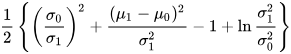

Where p is indexed 0 and q is indexed 1.  
torch.log is my default ln, the natural logarithm.

KL: only the disagreement

In [ ]:
0.5*((std_p/std_q)**2 + (mu_q - mu_p)**2/std_q**2 - 1 + torch.log(std_q**2/std_p**2))

tensor(0.3499)

In [ ]:
torch.log(std_q/std_p) + (std_p**2 + (mu_p - mu_q)**2)/(2*std_q**2) - 0.5

tensor(0.3499)

In [ ]:
0.5*((std_q/std_p)**2 + (mu_p - mu_q)**2/std_p**2 - 1 + torch.log(std_p**2/std_q**2))

tensor(0.7195)

In [ ]:
q_dist.icdf(torch.tensor(0.05))

tensor(5.0654)

In [ ]:
# inverse cdf
q_dist.icdf(torch.tensor(0.05))
p_dist.icdf(torch.tensor(0.05))

# c_dist.cdf(torch.tensor(4.3063))
c_dist.icdf(torch.tensor(0.05))

tensor(4.7103)

In [ ]:
# minimum 5% quantile
q_dist.icdf(torch.tensor(0.05))
p_dist.icdf(torch.tensor(0.05))
c_min = torch.min(q_dist.icdf(torch.tensor(0.05)), p_dist.icdf(torch.tensor(0.05)))
c_max = torch.max(q_dist.icdf(torch.tensor(0.95)), p_dist.icdf(torch.tensor(0.95)))

np.mean(c_min, c_max)

TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=Tensor, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


- Exploration-Exploitation Trade-off (e.g., Probability of Improvement, Expected Improvement, Upper Confidence Bound)
- Entropy-Based Methods (e.g., Predictive Entropy Search, Max-value Entropy Search, Entropy Search)
- Information-Theoretic Approaches (e.g., Mutual Information)
- Model-Based Approaches (e.g., Gaussian Process Upper Confidence Bound, Knowledge Gradient)
- Exploration-Exploitation Hybrid Approaches (e.g., Thompson Sampling)